### Methods

#### PTBXL filters

In [55]:
def butterworth_highpass(data = 0, cutoff = 0.5, fs = 500, order = 4):
  nyquist = 0.5 * fs
  normal_cutoff = cutoff / nyquist
  b, a = signal.butter(order, normal_cutoff, btype = "highpass")
  y = signal.lfilter(b, a, data)

  return y

def butterworth_lowpass(data = 0, cutoff = 200, fs = 500, order = 4):
  nyquist = 0.5 * fs
  normal_cutoff = cutoff / nyquist
  b, a = signal.butter(order, normal_cutoff, btype = "lowpass", analog=False)
  
  if len(data.shape) == 1:
      axis = 0
  else:
        axis = 1
  y = signal.lfilter(b, a, data, axis=axis)

  return y

def applyPTBXLFilters(data = 0, fs = 200, hCutoff = 0.5, hOrder = 4, lCutoff = 200, lOrder = 4, sWindow = 31, sPolyorder = 3):
    data = butterworth_highpass(data, cutoff = hCutoff, fs = fs, order = hOrder)
    data = butterworth_lowpass(data, cutoff = lCutoff, fs = fs, order = lOrder)
    data = signal.savgol_filter(data.squeeze(), window_length=sWindow, polyorder=sPolyorder)
    
    return data

#### Palm paper filters

In [8]:
from scipy.signal import butter, filtfilt, iirnotch

# 50 Hz Notch Filter to remove power-line noise
def notch_filter(data, fs=200, freq=50, quality_factor=30):
    b, a = iirnotch(freq, quality_factor, fs)
    y = filtfilt(b, a, data)
    return y

# Low-Pass Filter (Second-Order)
def lowpass_filter(data, cutoff=40, fs=200, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# High-Pass Filter
def highpass_filter(data, cutoff=0.5, fs=200, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y


def applyPalmFilters(data = 0, fs = 200, notchFreq = 50, notchQ = 30, lcutoff = 40, lorder = 4, hcutoff = 0.5, horder = 4):
    data = notch_filter(data, fs = fs, freq = notchFreq, quality_factor = notchQ)
    data = lowpass_filter(data, cutoff = lcutoff, fs = fs, order = lorder)
    data = highpass_filter(data, cutoff = hcutoff, fs = fs, order = horder)
    
    return data

# implementation variation 2
from scipy.signal import lfilter

def low_pass_filter(signal):
    # Filter coefficients based on the given transfer function in the paper
    b = [1, -2, 1]  # Numerator coefficients (1 - 2z^-10 + z^-20)
    a = [1, -2, 1]  # Denominator coefficients (1 - 2z^-1 + z^-2)
    
    # Apply the filter to the signal
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

def high_pass_filter(signal):
    # Step 1: Low-pass filter (as part of the high-pass design)
    b_lp = [1, -1]  # Numerator coefficients (1 - z^-240)
    a_lp = [1, -1]  # Denominator coefficients (1 - z^-1)
    low_pass_output = lfilter(b_lp, a_lp, signal)

    # Step 2: High-pass filter using the low-pass output
    b_hp = [1]  # Numerator coefficient for z^-120 (delay of 120 samples)
    a_hp = [240]  # Scaling by 240 (as per the paper's equation)
    high_pass_output = lfilter(b_hp, a_hp, low_pass_output)
    return high_pass_output

def applyPalmFiltersV2(data, fs = 200, notchFreq = 50, notchQ=30):
    filtered_ecg_signal = notch_filter(data, fs=fs, freq=notchFreq, quality_factor=notchQ)
    filtered_ecg_signal = low_pass_filter(filtered_ecg_signal)
    filtered_ecg_signal = high_pass_filter(filtered_ecg_signal)
    
    return filtered_ecg_signal

#### Other methods

In [3]:
def plot_ecg(ecg=0, title='ECG Signal', scale = 1):
    plt.figure(figsize=(2 * scale, 1 * scale))
    plt.plot(ecg)
    plt.title(title, fontsize="22")
    plt.xlabel('Samples', fontsize="18")
    plt.ylabel('Amplitude', fontsize="18")
    plt.show()
    
def plot_multiple_ecg(ecg = 0, plotCount = 1 , title = 'ECG Signal', scale = 1, recordName = None):
    if plotCount > len(ecg):
        plotCount = len(ecg)
    
    for i in range(plotCount):
        print(recordName[i])
        plot_ecg(ecg[i], title = title, scale = scale)
        
from scipy.fft import fft

def calculate_and_plot_frequency_spectrum(ecg=0, fs=200, title = 'Frequency Spectrum', scale = 1):
    fftRecord = fft(ecg)
    N = len(fftRecord)
    freqs = np.fft.fftfreq(N, 1/fs)
    
    plt.figure(figsize=(2 * scale, 1 * scale))
    plt.plot(freqs[:N//2], np.abs(fftRecord)[:N//2])
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()
    
    # f, Pxx = signal.periodogram(ecg, fs)
    # return f, Pxx
    
def calculate_and_plot_overlapping_frequency_spectrum(ecg1=0, ecg2=0, fs=200, title='Frequency Spectrum', scale=1):
    # Normalize both ECG signals
    ecg1_normalized = normalize_signal(ecg1)
    ecg2_normalized = normalize_signal(ecg2)
    
    # Calculate FFT for the first ECG signal
    fftRecord1 = fft(ecg1_normalized)
    N1 = len(fftRecord1)
    freqs1 = np.fft.fftfreq(N1, 1/fs)
    
    # Calculate FFT for the second ECG signal
    fftRecord2 = fft(ecg2_normalized)
    N2 = len(fftRecord2)
    freqs2 = np.fft.fftfreq(N2, 1/fs)
    
    # Plot both signals in the same figure
    plt.figure(figsize=(2 * scale, 1 * scale))
    
    # Plot the first signal
    plt.plot(freqs1[:N1//2], np.abs(fftRecord1)[:N1//2], label='Proposed', color='blue')
    
    # Plot the second signal
    plt.plot(freqs2[:N2//2], np.abs(fftRecord2)[:N2//2], label='PTBXL', color='red')
    
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.show()  

# Load ECG Signals from ANSI dataset

In [5]:
import os
from scipy import signal
import numpy as np
import wfdb
import matplotlib.pyplot as plt

Single reading

Multiple readings

In [44]:
datasetPath = r"C:\Users\USER\Documents\SLIIT\Datasets\ansiaami-ec13-test-waveforms-1.0.0\ansiaami-ec13-test-waveforms-1.0.0"
dataset_File_Names = None
dataset_ecg_readings = []

In [45]:
# Get all file names in the dataset directory
dataset_File_Names = [file for file in os.listdir(datasetPath) if file.endswith(".dat")]
print('dataset_File_Names: ', dataset_File_Names)
print('dataset_File_Names length: ', len(dataset_File_Names))

# read all files in the dataset directory
for file in dataset_File_Names:
    file_name = os.path.splitext(file)[0]
    print('file_name: ', file_name)
    ecg, details = wfdb.rdsamp(os.path.join(datasetPath, file_name))
    dataset_ecg_readings.append(ecg)
    
print('dataset_ecg_readings length: ', len(dataset_ecg_readings))

dataset_File_Names:  ['aami3a.dat', 'aami3b.dat', 'aami3c.dat', 'aami3d.dat', 'aami4a.dat', 'aami4a_d.dat', 'aami4a_h.dat', 'aami4b.dat', 'aami4b_d.dat', 'aami4b_h.dat']
dataset_File_Names length:  10
file_name:  aami3a
file_name:  aami3b
file_name:  aami3c
file_name:  aami3d
file_name:  aami4a
file_name:  aami4a_d
file_name:  aami4a_h
file_name:  aami4b
file_name:  aami4b_d
file_name:  aami4b_h
dataset_ecg_readings length:  10


# Load ECG Signals from Device Readings

#### Single reading

In [1]:
import numpy as np

In [68]:
poornas_ecg_path = r"C:\Users\USER\Documents\SLIIT\Projects\CardioFit-AI Model\Palm Analysis\Sample ECG\Poorna\2000.txt"

In [69]:
# Read file content
with open(poornas_ecg_path, 'r') as file:
    poornas_file_content = file.read().strip()  # Read and strip whitespace

# Remove unwanted characters (e.g., brackets)
poornas_file_content = poornas_file_content.strip('[]')

# Split by comma and convert to float
poornas_ecg = np.array([float(x) for x in poornas_file_content.split(',')])

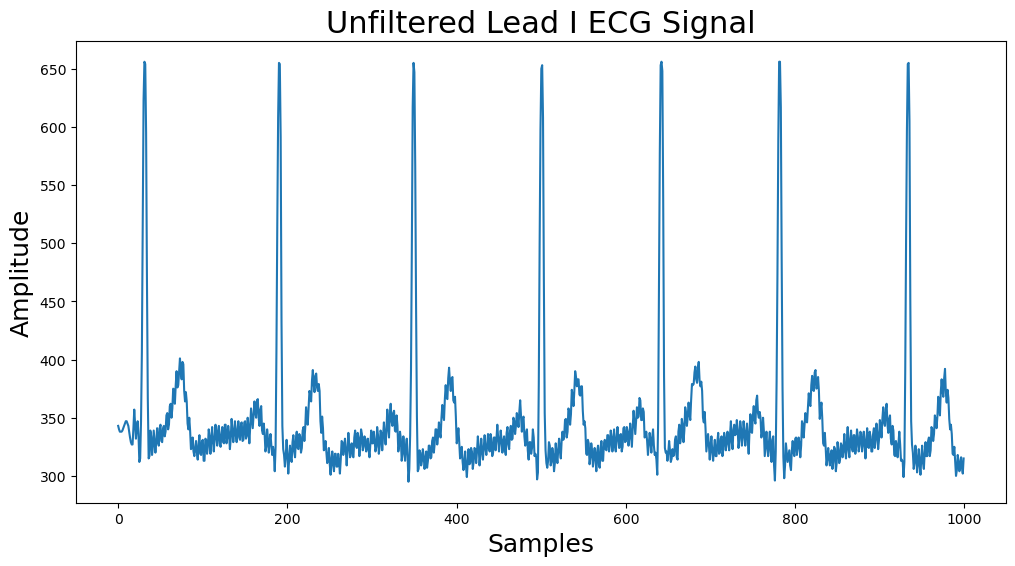

In [80]:
plot_ecg(ecg = poornas_ecg[:200*5], title='Unfiltered Lead I ECG Signal', scale=6)

In [71]:
# not good for poornas signal
# poornas_ptbxl_filtered_ecg = applyPTBXLFilters(poornas_ecg, fs=200, hCutoff=0.5, hOrder=4, lCutoff=50, lOrder=4, sWindow=31, sPolyorder=3)

# palm filtering version 1 - best
poornas_palm_filtered_ecg = applyPalmFilters(poornas_ecg, fs=200, notchFreq=50, notchQ=30, lcutoff=40, lorder=4, hcutoff=0.5, horder=4)

# palm filtering version 1 variant 2 - good
# poornas_palm_filtered_ecg2 = applyPalmFilters(poornas_ecg, fs=200, notchFreq=50, notchQ=30, lcutoff=40, lorder=2, hcutoff=0.5, horder=2)

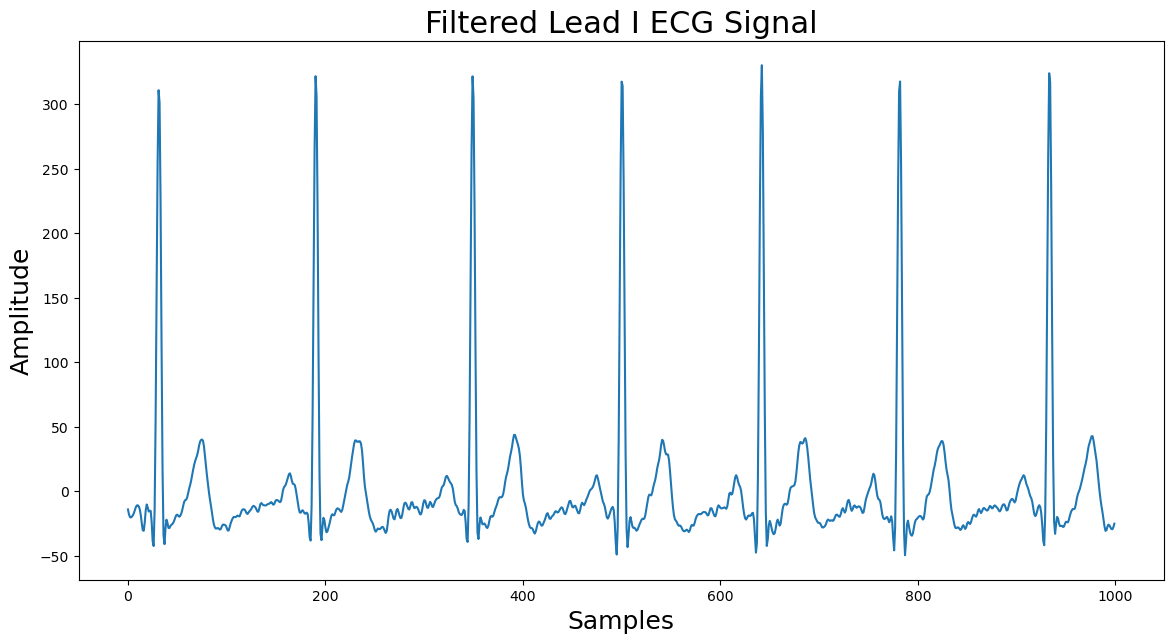

In [81]:
seconds = 5
# plot_ecg(ecg = poornas_ptbxl_filtered_ecg[:200 * seconds], title='Poorna PTBXL Filtered ECG Signal', scale=7)
plot_ecg(ecg = poornas_palm_filtered_ecg[:200 * seconds], title='Filtered Lead I ECG Signal', scale=7)
# plot_ecg(ecg = poornas_palm_filtered_ecg2[:200 * seconds], title='Poorna Palm Filtered ECG Signal 2', scale=7)

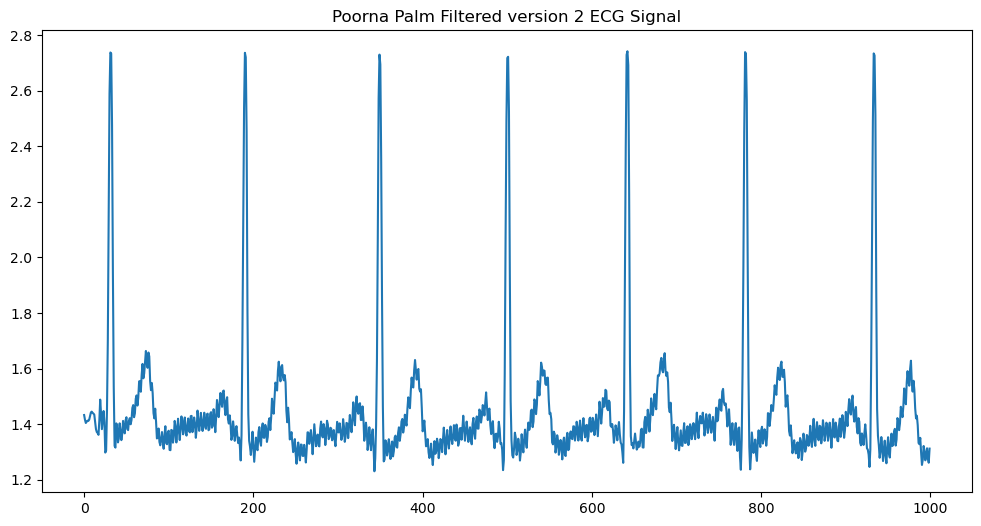

In [214]:
seconds = 2

#palm filtering version 2 - not good
poorna_palm_filter_ecg3 = applyPalmFiltersV2(poornas_ecg, fs = 200, notchFreq = 50, notchQ=30)
plot_ecg(ecg = poorna_palm_filter_ecg3[:200 * seconds], title='Poorna Palm Filtered version 2 ECG Signal', scale=6)

#### Multiple readings

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [4]:
my_ecg_path = r"C:\Users\USER\Documents\SLIIT\Projects\CardioFit-AI Model\Palm Analysis\Sample ECG"

In [5]:
my_ecg_file_list = [file for file in os.listdir(my_ecg_path) if file.endswith("raw2000.txt")]
print(my_ecg_file_list)
print('file count: ', len(my_ecg_file_list))

['15raw2000.txt', '1raw2000.txt', '2raw2000.txt', '4raw2000.txt', '6raw2000.txt', '7raw2000.txt']
file count:  6


In [6]:
#list to store my ECGs
myECGRecords = []
myFilteredECGRecords = []

#load ecg files
for index, file in enumerate(my_ecg_file_list):
    record_name = os.path.splitext(file)[0]
    ecg = np.loadtxt(os.path.join(my_ecg_path, record_name + ".txt"))
    myECGRecords.append(ecg)

15raw2000.txt


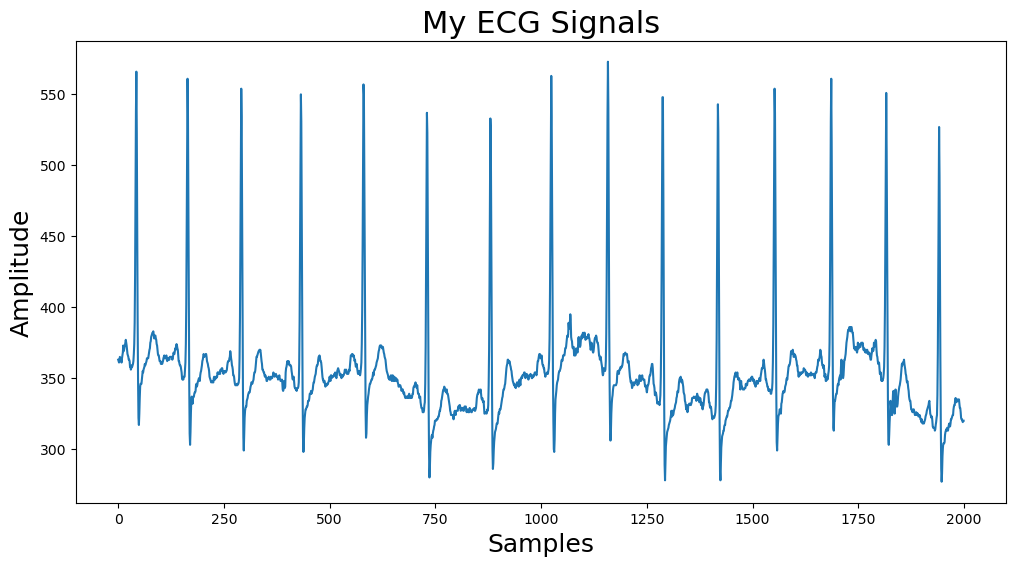

1raw2000.txt


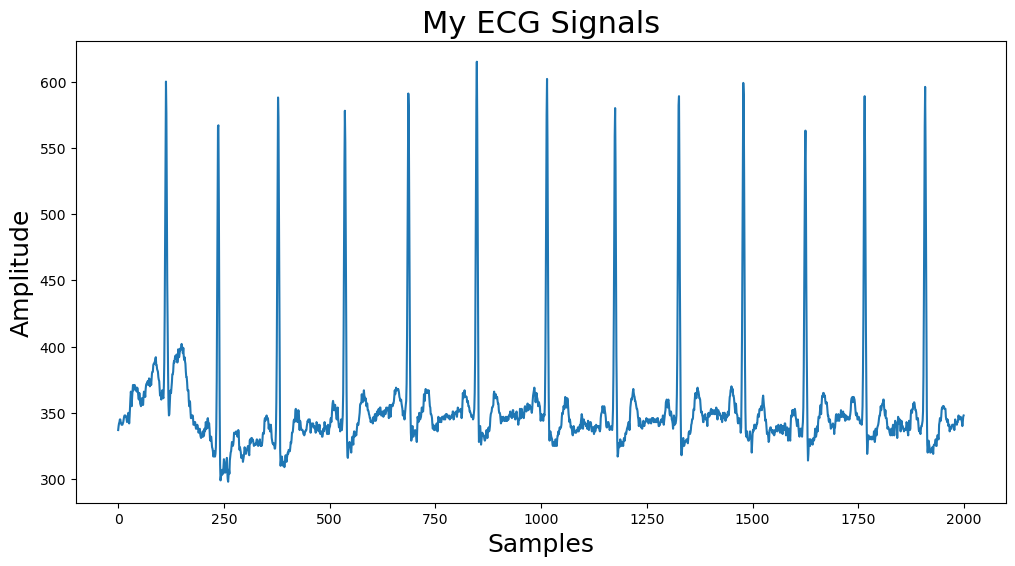

2raw2000.txt


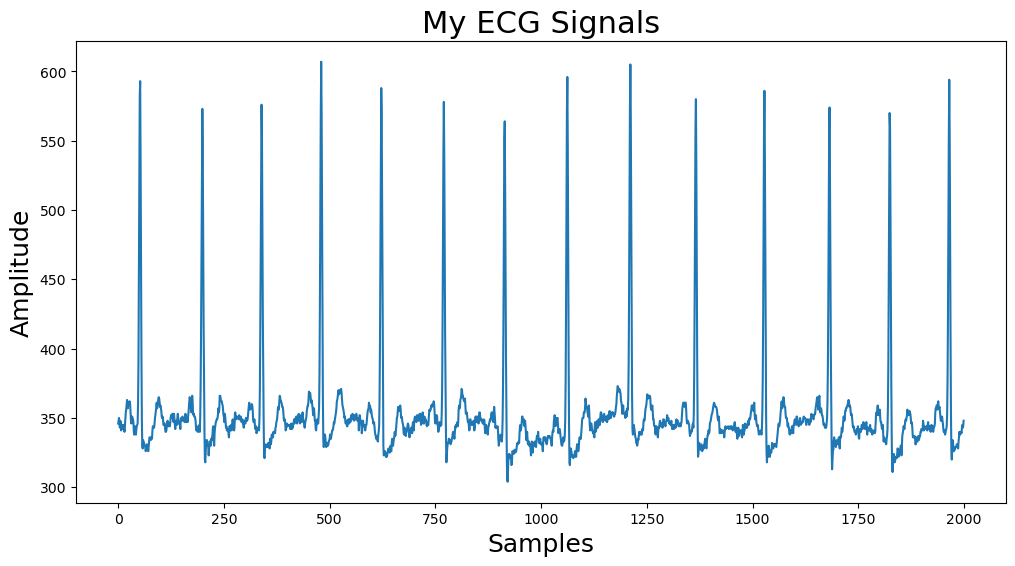

4raw2000.txt


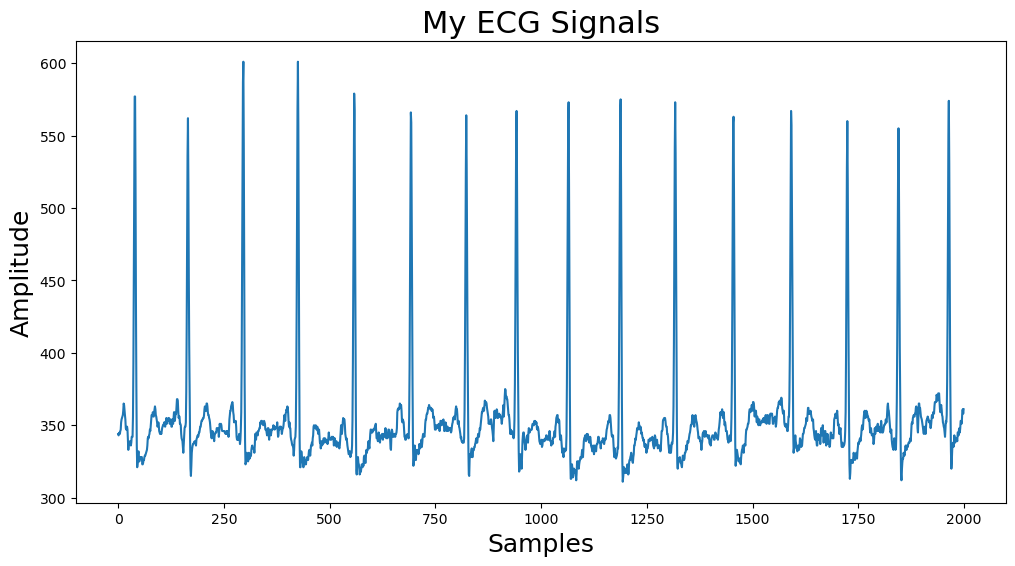

6raw2000.txt


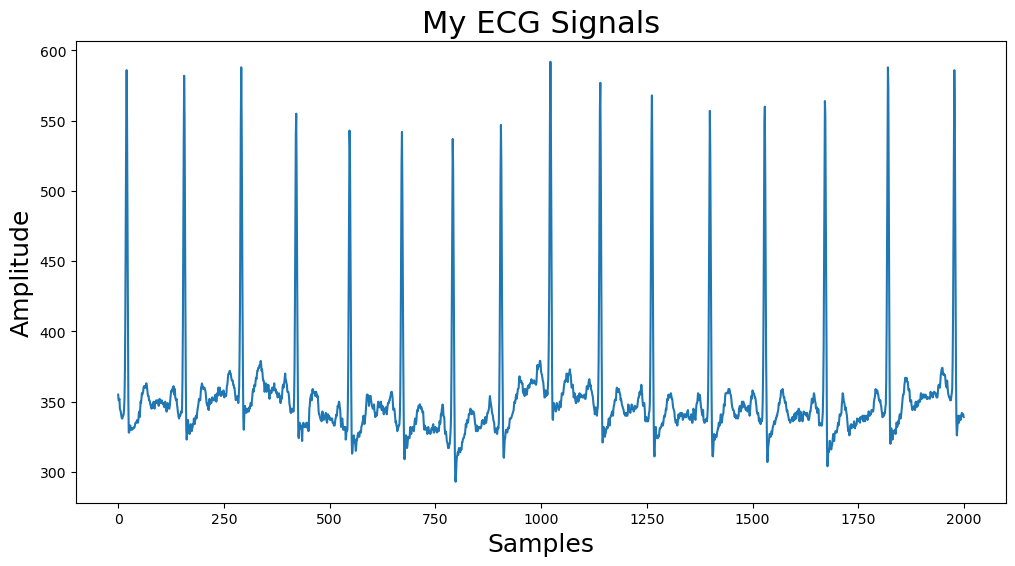

7raw2000.txt


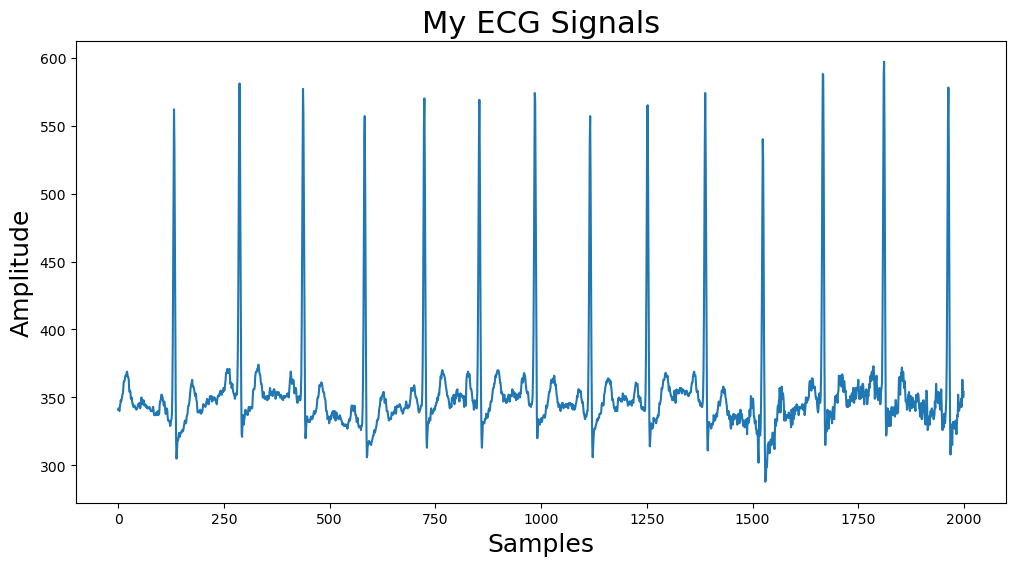

In [79]:
# plot all loaded raw ecgs
plot_multiple_ecg(myECGRecords, plotCount=len(myECGRecords), title='My ECG Signals', scale=6, recordName = my_ecg_file_list)

In [9]:
#Apply palm filter
for ecg in myECGRecords:
    myFilteredECGRecords.append(applyPalmFilters(ecg, fs=200, notchFreq=50, notchQ=30, lcutoff=90, lorder=4, hcutoff=0.5, horder=4))

In [ ]:
# calculate and plot frequency spectrum

for ecg in myFilteredECGRecords:
    calculate_and_plot_frequency_spectrum(ecg, fs=200, title='My ECG Frequency Spectrums', scale=6)

Single reading

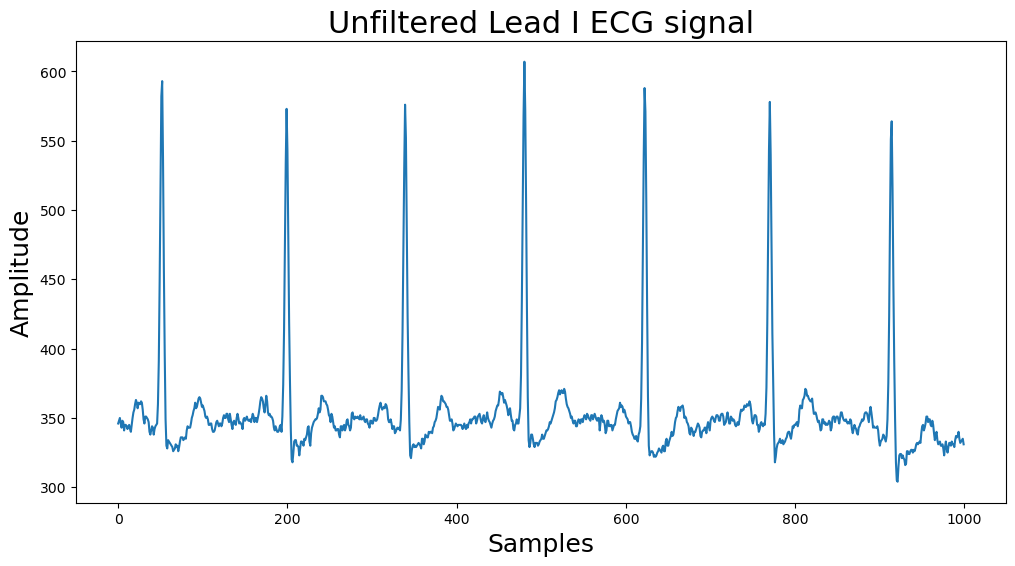

In [52]:
ecg2 = np.loadtxt(r"C:\Users\USER\Documents\SLIIT\Projects\CardioFit-AI Model\Palm Analysis\Sample ECG\2raw2000.txt")

plot_ecg(ecg2[:200*5], scale=6, title='Unfiltered Lead I ECG signal')

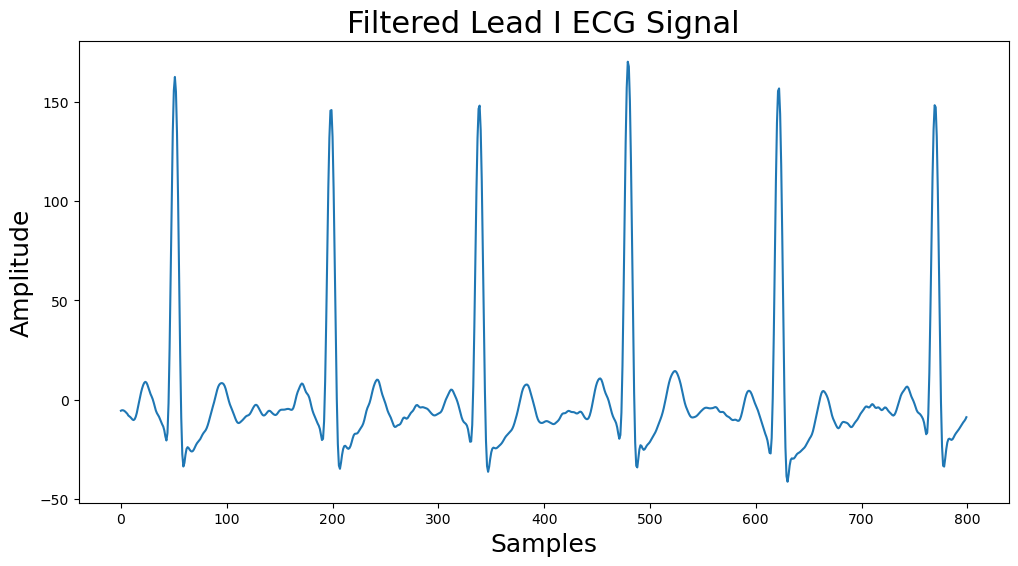

In [39]:
# ptbxlfilteredmyecg = applyPTBXLFilters(ecg2, fs=200, hCutoff=0.5, hOrder=4, lCutoff=50, lOrder=4, sWindow=31, sPolyorder=3)
palmfilteredmyecg = applyPalmFilters(ecg2, fs=200, notchFreq=50, notchQ=30, lcutoff=40, lorder=4, hcutoff=0.5, horder=4)

# plot_ecg(ptbxlfilteredmyecg, title= 'PTBXL Filtered ecg', scale=6)
plot_ecg(palmfilteredmyecg[:200*4], title='Filtered Lead I ECG Signal', scale=6)

# Calculate Frequency Spectrum

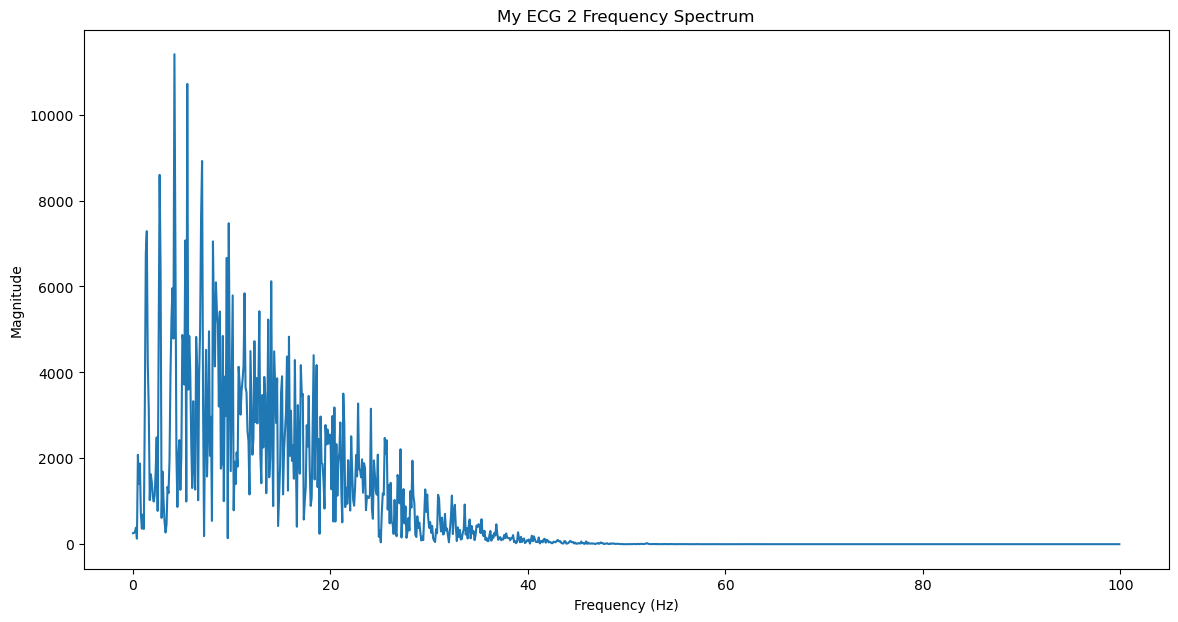

In [14]:
calculate_and_plot_frequency_spectrum(palmfilteredmyecg, fs=200, title='My ECG 2 Frequency Spectrum', scale=7)

Obtain frequency spectrum for ANSI Dataset

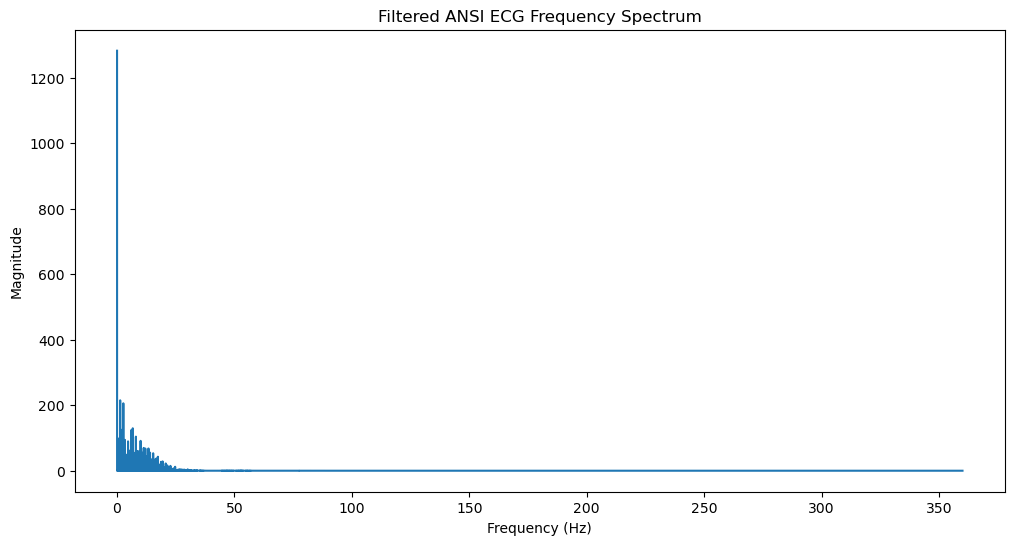

In [56]:
filteredAnsi = applyPTBXLFilters(data = dataset_ecg_readings[0], fs = 720, hCutoff = 0.5, hOrder = 4, lCutoff = 200, lOrder = 4, sWindow = 31, sPolyorder = 3)
# filteredAnsi = applyPalmFilters(data = dataset_ecg_readings[0], fs = 720, notchFreq = 50, notchQ = 30, lcutoff = 300, lorder = 4, hcutoff = 0.5, horder = 4)

calculate_and_plot_frequency_spectrum(filteredAnsi, fs=720, title='Filtered ANSI ECG Frequency Spectrum', scale=6)

Load PTBXL ECG

In [15]:
import wfdb

In [74]:
ptbxlpath1 = r"C:\Users\USER\Documents\SLIIT\Projects\CardioFit-AI Model\Palm Analysis\Sample ECG\PTBXL-Lead 1\03536_hr"
ptbxlpath2 = r"C:\Users\USER\Documents\SLIIT\Projects\CardioFit-AI Model\Palm Analysis\Sample ECG\PTBXL-Lead 1\02024_hr"
ptbxlpath3 = r"C:\Users\USER\Documents\SLIIT\Projects\CardioFit-AI Model\Palm Analysis\Sample ECG\PTBXL-Lead 1\09752_hr"


ptbxlecg, otherFields = wfdb.rdsamp(ptbxlpath3, channels=[0])

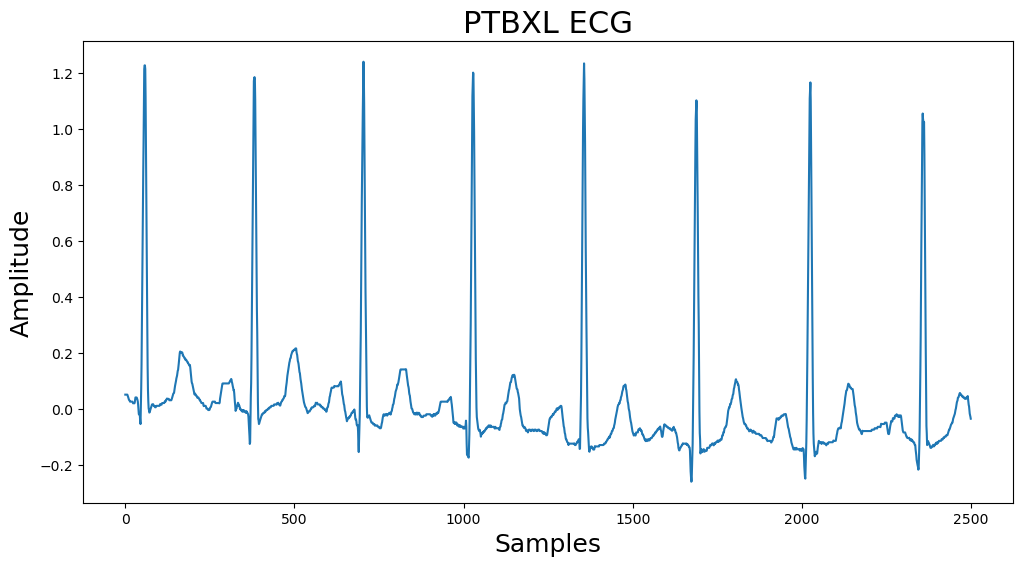

In [75]:
plot_ecg(ptbxlecg[:500*5], title='PTBXL ECG', scale=6)

In [12]:
def downsampleECG(ecg = [], original_fs = 500, target_fs = 200):
    samples = int(len(ecg) * target_fs / original_fs)
    downsampled_ecg = signal.resample(ecg, samples)
    
    return downsampled_ecg

downsampled_ecg = downsampleECG(ecg = ptbxlecg.squeeze(), original_fs = 500, target_fs = 200)

In [13]:
filteredptbxlecg = applyPalmFilters(data = downsampled_ecg, fs = 200, notchFreq = 50, notchQ = 30, lcutoff = 40, lorder = 4, hcutoff = 0.5, horder = 4)

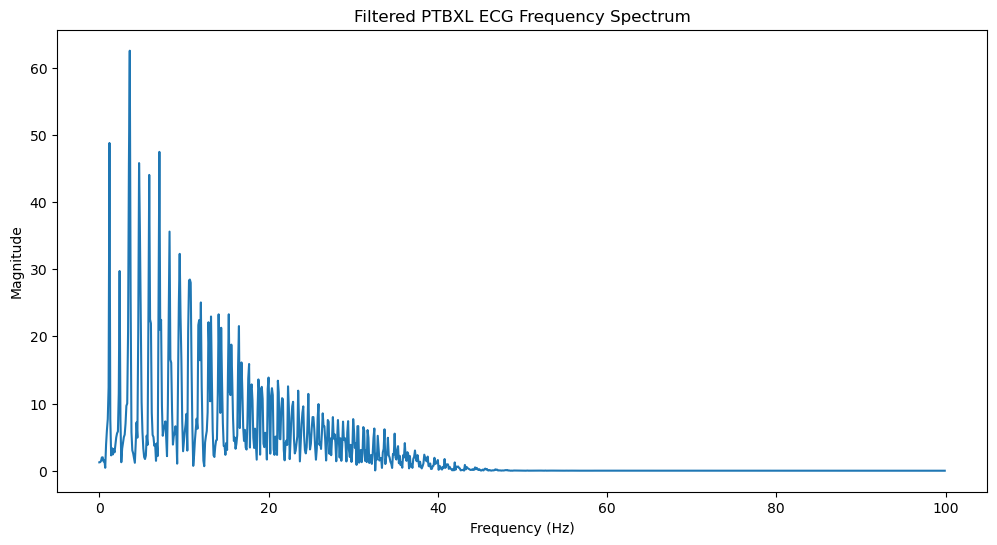

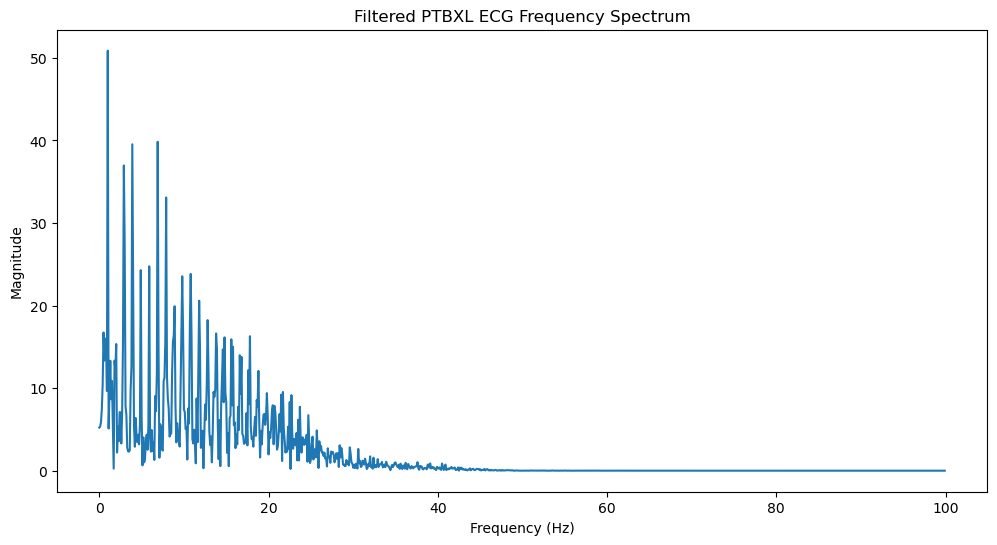

In [14]:
calculate_and_plot_frequency_spectrum(filteredptbxlecg, fs=200, title='Filtered PTBXL ECG Frequency Spectrum', scale=6)

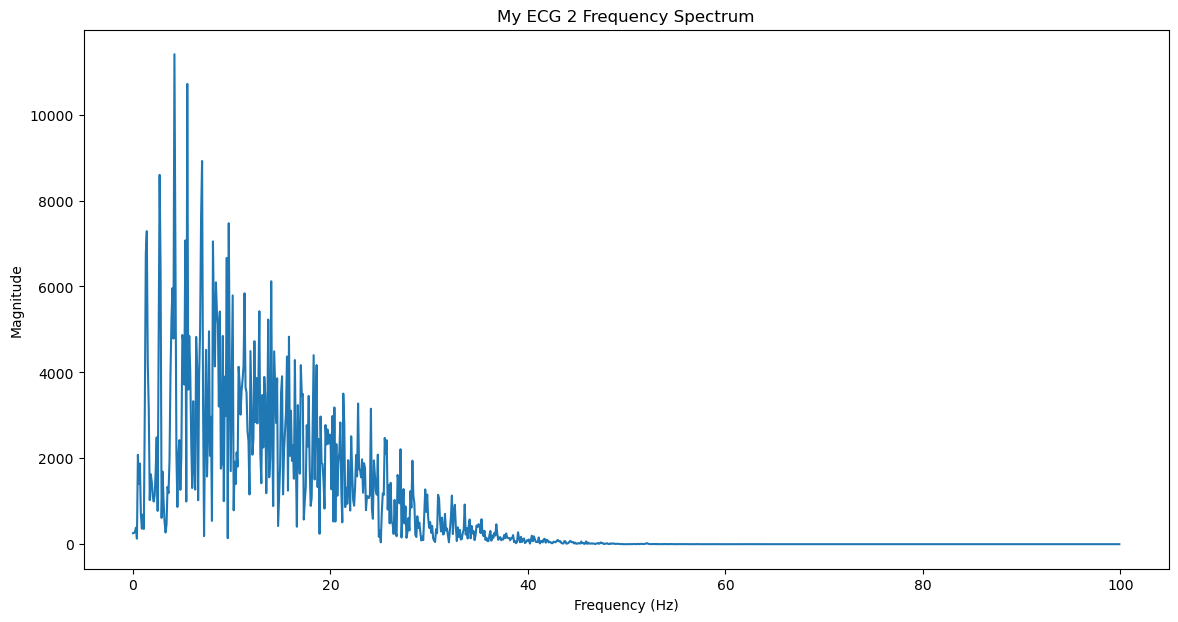

In [21]:
calculate_and_plot_frequency_spectrum(palmfilteredmyecg, fs=200, title='My ECG 2 Frequency Spectrum', scale=7)

In [15]:
def normalize_signal(signal):
    return signal / np.max(np.abs(signal))

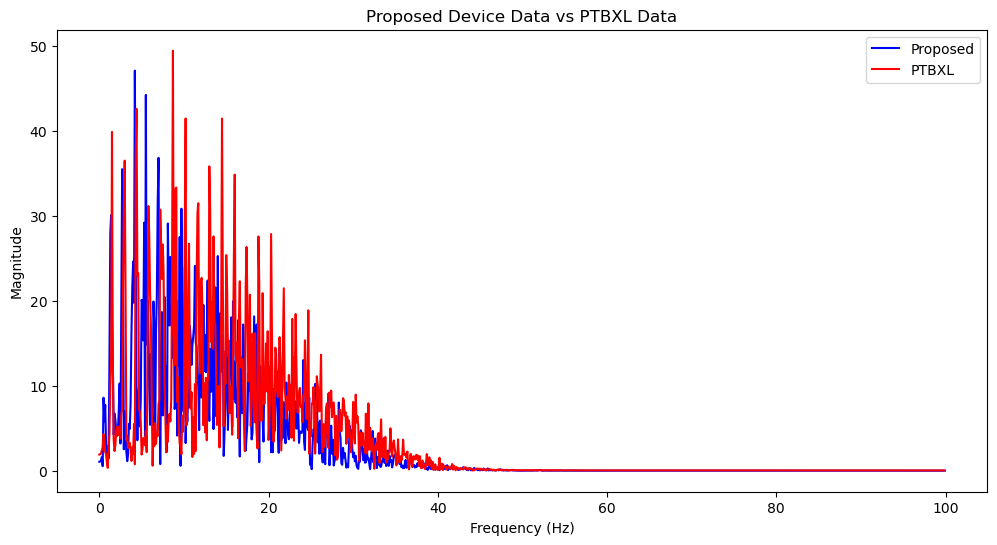

In [95]:
calculate_and_plot_overlapping_frequency_spectrum(palmfilteredmyecg, filteredptbxlecg, fs=200, title='Proposed Device Data vs PTBXL Data', scale=6)

In [54]:
def calculate_and_plot_sidebyside_frequency_spectrum(ecg1=0, ecg2=0, fs=200, title='Frequency Spectrum', scale=1):
    fontsize = 22
    # Normalize both ECG signals
    ecg1_normalized = normalize_signal(ecg1)
    ecg2_normalized = normalize_signal(ecg2)
    
    # Calculate FFT for the first ECG signal
    fftRecord1 = fft(ecg1_normalized)
    N1 = len(fftRecord1)
    freqs1 = np.fft.fftfreq(N1, 1/fs)
    
    # Calculate FFT for the second ECG signal
    fftRecord2 = fft(ecg2_normalized)
    N2 = len(fftRecord2)
    freqs2 = np.fft.fftfreq(N2, 1/fs)
    
    # Plot both signals in the same figure
    plt.figure(figsize=(2 * scale, 1 * scale))
    
    # Plot the first signal
    plt.subplot(1, 2, 1), plt.plot(freqs1[:N1//2], np.abs(fftRecord1)[:N1//2], label='Proposed\ndevice', color='blue')
    plt.xlabel('Frequency (Hz)', fontdict={'fontsize':fontsize})
    plt.ylabel('Magnitude', fontdict={'fontsize':fontsize})
    plt.legend(fontsize=f"{fontsize}")
    
    # Plot the second signal
    plt.subplot(1, 2, 2), plt.plot(freqs2[:N2//2], np.abs(fftRecord2)[:N2//2], label='PTB-XL', color='red')
    
    plt.suptitle(title, fontsize=f"{fontsize}")
    plt.xlabel('Frequency (Hz)', fontdict={'fontsize':fontsize})
    plt.ylabel('Magnitude', fontdict={'fontsize':fontsize})
    plt.legend(fontsize=f"{fontsize}")
    plt.show()  

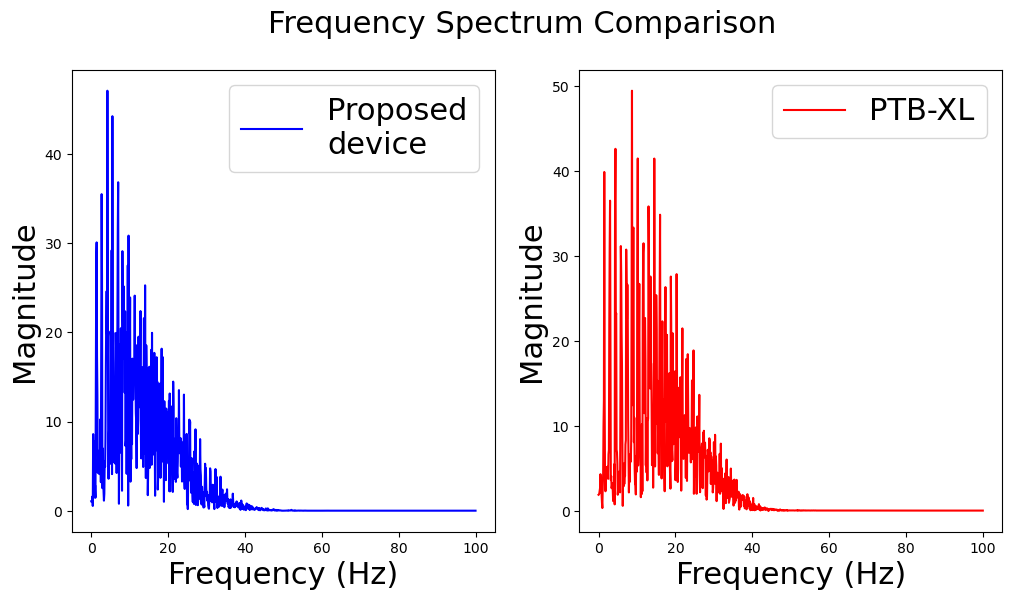

In [55]:
calculate_and_plot_sidebyside_frequency_spectrum(palmfilteredmyecg, filteredptbxlecg, fs=200, title='Frequency Spectrum Comparison', scale=6)

Metrics

In [40]:
proposedFFT = fft(palmfilteredmyecg)
N1 = len(proposedFFT)

ptbxlFFT = fft(filteredptbxlecg)
N2 = len(ptbxlFFT)

Spectral Correlation

In [41]:
def spectral_correlation(fft1, fft2):
    return np.corrcoef(np.abs(fft1), np.abs(fft2))[0, 1]

# Example usage
correlation = spectral_correlation(proposedFFT[:N1//2], ptbxlFFT[:N2//2])
print("Spectral Correlation:", correlation)

Spectral Correlation 1: 0.44606675108849964
Spectral Correlation 2: 0.5482945818711451


Root Mean Square Error (RMSE)

In [93]:
def spectral_rmse(fft1, fft2):
    return np.sqrt(np.mean((np.abs(fft1) - np.abs(fft2))**2))

# Example usage
rmse = spectral_rmse(proposedFFT[:N1//2], ptbxlFFT[:N2//2])
print("Spectral RMSE:", rmse)

Spectral RMSE: 1657.234198709666


In [72]:
def calculate_spectral_correlation(sig1_200fs, sig2_500fs):    
    sig2_500fs = downsampleECG(ecg = sig2_500fs.squeeze(), original_fs = 500, target_fs = 200)
    
    # filter signals
    sig1_200fs = applyPalmFilters(sig1_200fs, fs=200, notchFreq=50, notchQ=30, lcutoff=40, lorder=4, hcutoff=0.5, horder=4)
    sig1_200fs = signal.savgol_filter(sig1_200fs.squeeze(), window_length=11, polyorder=3)
    sig2_500fs = applyPalmFilters(sig2_500fs, fs=200, notchFreq=50, notchQ=30, lcutoff=40, lorder=4, hcutoff=0.5, horder=4)
    sig2_500fs = signal.savgol_filter(sig2_500fs.squeeze(), window_length=11, polyorder=3)
    
    # normalize signals
    sig1_200fs = normalize_signal(sig1_200fs)
    sig2_500fs = normalize_signal(sig2_500fs) 
    
    plot_ecg(sig1_200fs[:200*5], scale=6, title='Filtered Palm Lead I ECG signal')
    plot_ecg(sig2_500fs[:200*5], scale=6, title='Filtered PTBXL Lead I ECG signal')
    
    # calculate fft
    fft1 = fft(sig1_200fs)
    N1 = len(fft1)

    fft2 = fft(sig2_500fs)
    N2 = len(fft2)
    
    # calculate spectral correlation
    corr = spectral_correlation(fft1[:N1//2], fft2[:N2//2])
    print("Spectral Correlation:", corr)

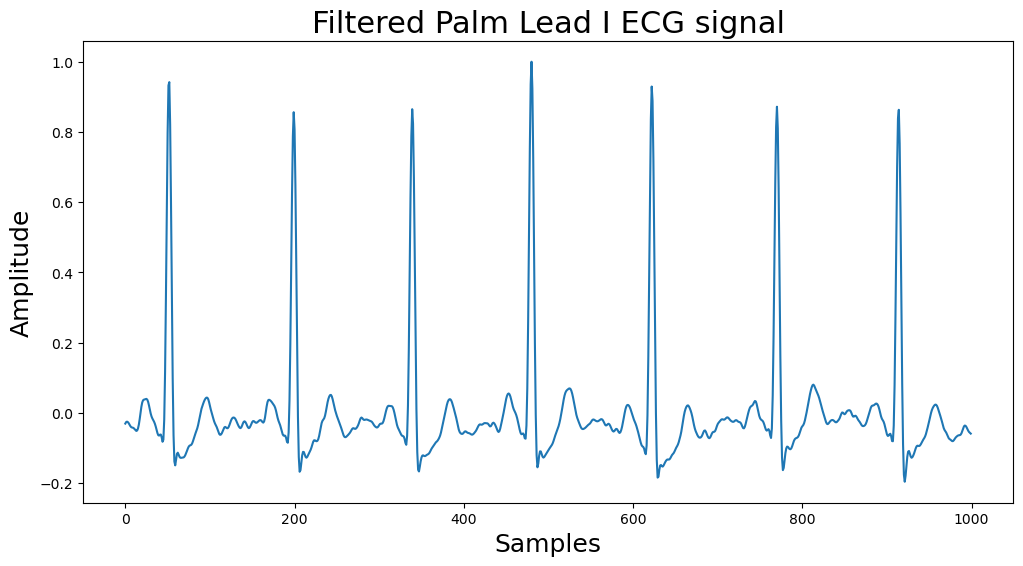

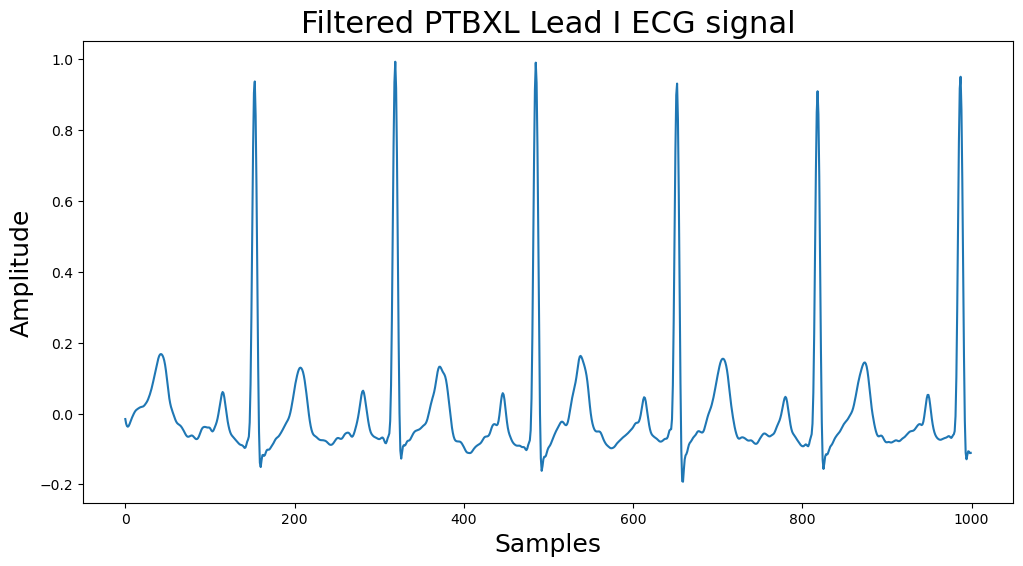

Spectral Correlation: 0.48785158277199037


In [73]:
calculate_spectral_correlation(sig1_200fs=ecg2, sig2_500fs=ptbxlecg)